In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageStat
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import keras

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
import shutil


loading the data

In [2]:
data = pd.read_csv('../dataset/train.csv')


#### calculate brightness of image
this function opens image in current working directory, converts to greyscale,
and pulls a float value for brightness by average pixel brightness.

In [3]:
def get_brightness(data):
    img_src = Image.open('img.png').convert('L')
    img_src.save("img_greyscale.png") # saving this image to show comparison
    stat = ImageStat.Stat(img_src)
    brightness = stat.mean[0]
    return brightness

#### downloading the images
checks the image url, if there isn't thumbnail_url - put 0 as default.
else creating request to downloading the image and calculating the brightness,
then saving it to brightness.csv


In [4]:
def get_img_from_url(data):
    bright_list = {'brightness': []}
    for i in range(len(data)):
        try:
          if str(data['thumbnail_url'][i]) == 'nan':
              data['brightness'] = 0
              bright_list['brightness'].append(0)
              continue
          response = requests.get(data['thumbnail_url'][i], stream=True)
          with open('img.png', 'wb') as out_file:
              shutil.copyfileobj(response.raw, out_file)
          del response
          brightness = get_brightness(data)
          bright_list['brightness'].append(brightness)

          if i % 100 == 0:
            print("len", len(bright_list['brightness']), "i", i)
            df = pd.DataFrame(bright_list)
            df.to_csv('../dataset/brightness.csv')
        except:
          bright_list['brightness'].append(0)
            
    return bright_list



In [5]:
#
# bright_list = get_img_from_url(data)
# df = pd.DataFrame(bright_list)
# df.to_csv('../dataset/brightness.csv')



### image model
for this section we use exist model that using inception v3 that was pre-train on image_net dataset.
the above model can be found this git: https://github.com/moe18/Image-Based-Airbnb-Pricing-Algorithm.git


In [6]:
Airbnb_data = pd.read_csv('../dataset/listings.csv')
Airbnb_data['price'] = Airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)
Airbnb_data = Airbnb_data.sample(frac=1)

# remove all listings where the price is less then 500
Airbnb_data = Airbnb_data[Airbnb_data.price < 500]

# how many listings have a price of zero
len(Airbnb_data.loc[Airbnb_data['price'] == 0])
# if the price is less then 10 revome the listing
Airbnb_data = Airbnb_data[Airbnb_data.price > 10]

d:\users\liels\onedrive\desktop\airbnbprice\venv\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


creating request to 6000 images, resizing them and return the images list and price list

In [7]:
def get_img():
  img_list = []
  price_list = []
  data_dict=()
  for i in range(502):#len(Airbnb_data['price'])):
    try:
      if i % 100 == 0:
        # gets 6,000 images
        print(int((i/500)*100),'% done')#len(data['price']))*100)
      response = requests.get(Airbnb_data['picture_url'][i])
      img = Image.open(BytesIO(response.content)).resize([224,224])

      img = np.array(img) / 255.0 # makes imputs [0,1]
      if img.shape == (224,224,3):
        img_list.append(img)
        price_list.append(Airbnb_data.price[i])
    except (KeyError or OSError):
      pass
  return img_list, price_list

In [8]:
X, y = get_img()
len(X)

0 % done
20 % done
40 % done
60 % done
80 % done
100 % done


486

split up the training set and test set


In [9]:
train_X = np.asarray(X[:350])
train_y = np.array(y[:350])
test_X = np.asarray(X[350:])
test_y = np.array(y[350:])
len(test_y)

136

define the InceptionV3 model and the image model layers.
then building, compiling and fitting the image model.

In [10]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = Dropout(.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='selu')(x)
x = Dropout(.5)(x)
# and output layer
predictions = Dense(1)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mse',metrics=['mse','mae'])

# train the model on the new data for a few epochs
model.fit(train_X[:200],train_y[:200],steps_per_epoch=10, epochs=3,validation_split = 0.2,validation_steps=10)


Epoch 1/3
10/10 [==============================] - 16s 1s/step - loss: 7201.3174 - mse: 7201.3174 - mae: 60.9798 - val_loss: 7132.3218 - val_mse: 7132.3218 - val_mae: 59.2042

In [11]:
pred = model.predict(test_X)
print(np.sqrt(np.mean((pred - test_y)**2)))


5/5 [==============================] - 10s 1s/step
108.96172100846746


actual prediction vs. model prediction

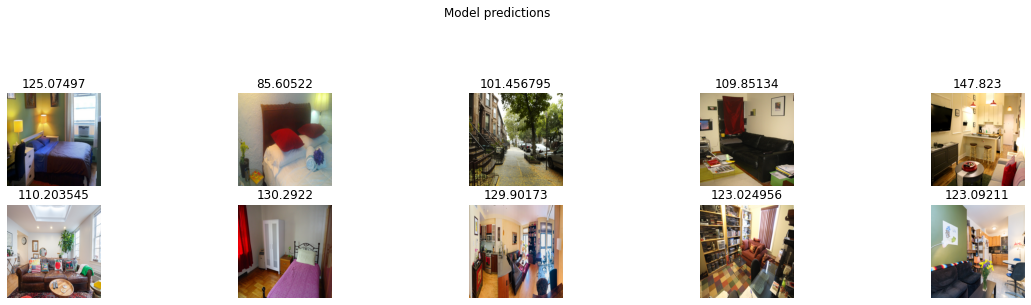

In [14]:
plt.figure(figsize=(20,12))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(test_X[n])
  plt.title(pred[n][0])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

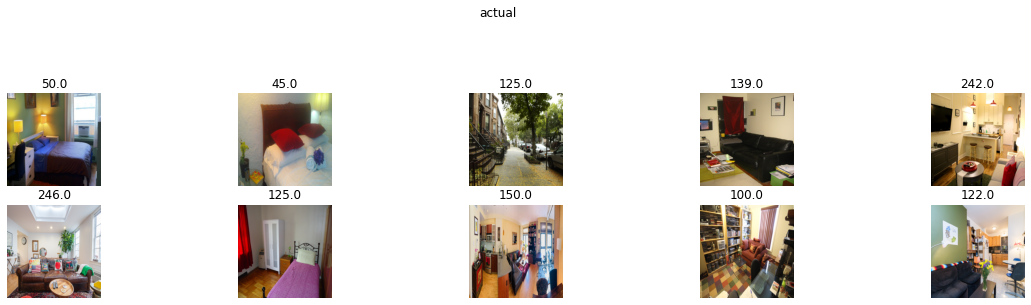

In [15]:
plt.figure(figsize=(20,12))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.imshow(test_X[n])
  plt.title(test_y[n])
  plt.axis('off')
_ = plt.suptitle("actual")

In [16]:
model.save("../dataset/image_model_500_new")
model.save("../dataset/image_model_500_new.h5")



INFO:tensorflow:Assets written to: ../dataset/image_model_500_new\assets


INFO:tensorflow:Assets written to: ../dataset/image_model_500_new\assets


getting the images and making prediction, saving the prediction to new csv

In [17]:
def get_img_from_url(data):
    import math
    price_by_model_list = {'price_by_model': []}
    for i in range(len(data)):
        try:
          pred = []
          if str(data['thumbnail_url'][i]) == 'nan':
            # data['price_by_model'] = 0
            price_by_model_list['price_by_model'].append(0)
            continue
          response = requests.get(data['thumbnail_url'][i])
          img = Image.open(BytesIO(response.content)).resize([224,224])
          img = np.array(img) / 255.0 # makes imputs [0,1]
          perd = model.predict(np.asarray([img]))[0][0]
          price_by_model_list['price_by_model'].append(perd)
          if i % 100 == 0:
            print(i, perd)
            print("len", len(price_by_model_list['price_by_model']), "i", i)
            df = pd.DataFrame(price_by_model_list)
            df.to_csv('../dataset/price_by_model.csv')
        except:
          price_by_model_list['price_by_model'].append(0)
            
    return price_by_model_list


In [18]:
# data = pd.read_csv('../dataset/train.csv')
# price_by_model_list = get_img_from_url(data)
# df = pd.DataFrame(price_by_model_list)
# df.to_csv('../dataset/price_by_model.csv')